# PRO GAN

In [ ]:
# !pip install kaggle matplotlib torchsummary tensorboard scipy
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces

# import shutil
# shutil.unpack_archive('140k-real-and-fake-faces.zip')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from math import log2
from scipy.stats import truncnorm
import random
import numpy as np
import os

## Config

In [3]:
os.makedirs("models", exist_ok=True)
class Config:
    START_TRAIN_AT_IMG_SIZE = 128
    DATASET = 'real_vs_fake/real-vs-fake/train'
    CHECKPOINT_GEN = "models/generator.pth"
    CHECKPOINT_CRITIC = "models/critic.pth"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SAVE_MODEL = True
    LOAD_MODEL = False
    LEARNING_RATE = 1e-3
    BATCH_SIZES = [32, 32, 32, 16, 16, 16, 16, 8, 4]
    CHANNELS_IMG = 3
    Z_DIM = 256
    IN_CHANNELS = 256
    CRITIC_ITERATIONS = 1
    LAMBDA_GP = 10
    PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)
    FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
    NUM_WORKERS = 4

config = Config()

## Model

In [4]:
"""
Implementation of ProGAN generator and discriminator with the key
attributions from the paper. We have tried to make the implementation
compact but a goal is also to keep it readable and understandable.
Specifically the key points implemented are:

1) Progressive growing (of model and layers)
2) Minibatch std on Discriminator
3) Normalization with PixelNorm
4) Equalized Learning Rate (here I cheated and only did it on Conv layers)
"""
"""
Factors is used in Discrmininator and Generator for how much
the channels should be multiplied and expanded for each layer,
so specifically the first 5 layers the channels stay the same,
whereas when we increase the img_size (towards the later layers)
we decrease the number of chanels by 1/2, 1/4, etc.
"""
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]


class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)


class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)



Z_DIM = 100
IN_CHANNELS = 256
gen = Generator(Z_DIM, IN_CHANNELS, img_channels=3)
critic = Discriminator(Z_DIM, IN_CHANNELS, img_channels=3)

for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    num_steps = int(log2(img_size / 4))
    x = torch.randn((1, Z_DIM, 1, 1))
    z = gen(x, 0.5, steps=num_steps)
    assert z.shape == (1, 3, img_size, img_size)
    out = critic(z, alpha=0.5, steps=num_steps)
    assert out.shape == (1, 1)
    print(f"Success! At img size: {img_size}")

/tmp/ipykernel_1231/790883027.py:176: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])


Success! At img size: 4
Success! At img size: 8
Success! At img size: 16
Success! At img size: 32
Success! At img size: 64
Success! At img size: 128
Success! At img size: 256
Success! At img size: 512
Success! At img size: 1024


## Utils

In [5]:
# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(gen, steps, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, config.Z_DIM, 1, 1)), device=config.DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

## Training

In [6]:
torch.backends.cudnn.benchmarks = True


def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(config.CHANNELS_IMG)],
                [0.5 for _ in range(config.CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = config.BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=config.DATASET, transform=transform)
    dataset = datasets.ImageFolder(root=config.DATASET, transform=transform)
    class_idx = dataset.class_to_idx["real"]
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    subset_indices = random.sample(class_indices, 25000)
    subset_dataset = Subset(dataset, subset_indices)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset


def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(config.DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=config.DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + config.LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (config.PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(config.FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                tensorboard_step,
            )
            tensorboard_step += 1

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

    return tensorboard_step, alpha



# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
# but really who cares..
gen = Generator(
    config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
).to(config.DEVICE)
critic = Discriminator(
    config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99)
)
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()

# for tensorboard plotting
writer = SummaryWriter(f"logs/gan1")

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,
    )
    load_checkpoint(
        config.CHECKPOINT_CRITIC, critic, opt_critic, config.LEARNING_RATE,
    )

gen.train()
critic.train()

tensorboard_step = 0
# start at step that corresponds to img size that we set in config
step = int(log2(config.START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in config.PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5  # start with very low alpha
    loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        tensorboard_step, alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
            tensorboard_step,
            writer,
            scaler_gen,
            scaler_critic,
        )

        if config.SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
            save_checkpoint(critic, opt_critic, filename=config.CHECKPOINT_CRITIC)

    step += 1  # progress to the next img size

Current image size: 128
Epoch [1/30]


100%|██████████| 6250/6250 [20:55<00:00,  4.98it/s, gp=0.0174, loss_critic=-3.01]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 6250/6250 [20:53<00:00,  4.99it/s, gp=0.0186, loss_critic=-.801]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


  3%|▎         | 189/6250 [00:38<20:50,  4.85it/s, gp=0.00669, loss_critic=-3.17]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.97916067..0.9392615].


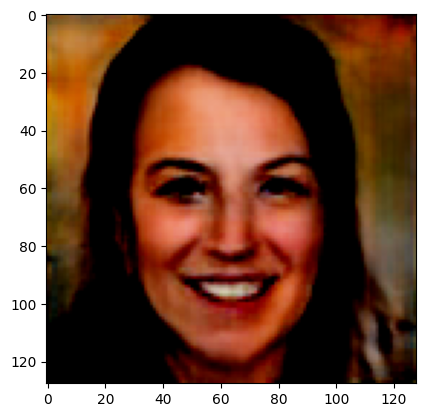

In [29]:
import matplotlib.pyplot as plt

noise = torch.randn(1, config.Z_DIM, 1, 1).to(config.DEVICE)
fake = gen(noise, alpha, step).squeeze()
plt.imshow(fake.cpu().detach().permute(1, 2, 0)  )

# PASTED

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# # ! unzip -q 140k-real-and-fake-faces.zip

# import shutil
# shutil.unpack_archive('140k-real-and-fake-faces.zip')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from math import log2
from scipy.stats import truncnorm
import random
import numpy as np
import os

# Configuration
class Config:
    START_TRAIN_AT_IMG_SIZE = 128
    DATASET = 'real_vs_fake/real-vs-fake/train'
    CHECKPOINT_GEN = "generator.pth"
    CHECKPOINT_CRITIC = "critic.pth"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SAVE_MODEL = True
    LOAD_MODEL = False
    LEARNING_RATE = 1e-3
    BATCH_SIZES = [32, 32, 32, 16, 16, 16, 16, 8, 4]
    CHANNELS_IMG = 3
    Z_DIM = 256
    IN_CHANNELS = 256
    CRITIC_ITERATIONS = 1
    LAMBDA_GP = 10
    PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)
    FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
    NUM_WORKERS = 4

config = Config()

# Weight Scaled Convolution
class WSConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )
        self.initial_rgb = WSConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0)
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([self.initial_rgb])

        factors = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32]
        for i in range(len(factors) - 1):
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0))

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        factors = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32][::-1]
        for i in range(len(factors) - 1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0))

        self.initial_rgb = WSConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.final_block = nn.Sequential(
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, 1, kernel_size=1, padding=0, stride=1),
        )

    def fade_in(self, alpha, downscaled, out):
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        cur_step = len(self.prog_blocks) - steps

        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

# Utility functions
def plot_to_tensorboard(writer, loss_critic, loss_gen, real, fake, tensorboard_step):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        img_grid_real = make_grid(real[:8], normalize=True)
        img_grid_fake = make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)

def gradient_penalty(critic, real, fake, alpha, train_step, device):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    mixed_scores = critic(interpolated_images, alpha, train_step)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(gen, steps, truncation=0.7, n=100):
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, config.Z_DIM, 1, 1)), device=config.DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

# Training function
def train_fn(critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen, tensorboard_step, writer, scaler_gen, scaler_critic):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(config.DEVICE)
        cur_batch_size = real.shape[0]

        noise = torch.randn(cur_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=config.DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + config.LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad(set_to_none=True)
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad(set_to_none=True)
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        alpha += cur_batch_size / ((config.PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset))
        alpha = min(alpha, 1)

        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(config.FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(writer, loss_critic.item(), loss_gen.item(), real.detach(), fixed_fakes.detach(), tensorboard_step)
            tensorboard_step += 1

        loop.set_postfix(gp=gp.item(), loss_critic=loss_critic.item())

    return tensorboard_step, alpha

# Main training loop
def main():
    gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)
    critic = Discriminator(config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)
    opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
    opt_critic = optim.Adam(critic.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()

    writer = SummaryWriter(f"logs/gan1")

    if config.LOAD_MODEL:
        load_checkpoint(
            config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_CRITIC, critic, opt_critic, config.LEARNING_RATE,
        )

    gen.train()
    critic.train()

    tensorboard_step = 0
    # start at step that corresponds to img size that we set in config
    step = int(log2(config.START_TRAIN_AT_IMG_SIZE / 4))
    for num_epochs in config.PROGRESSIVE_EPOCHS[step:]:
        alpha = 1e-5  # start with very low alpha
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            tensorboard_step, alpha = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                tensorboard_step,
                writer,
                scaler_gen,
                scaler_critic,
            )

            if config.SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
                save_checkpoint(critic, opt_critic, filename=config.CHECKPOINT_CRITIC)

        step += 1  # progress to the next img size